In [1]:
import numpy as np
import pandas as pd
import Variables_Nuevas as VN
import folium
from folium import Map, Circle
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')

ruta='/Users/nico/Desktop/Data Science/TFM/Energy Forecast/Datos Pablo/'
client=pd.read_csv(ruta+'client_actualizado.csv')
elec=pd.read_csv(ruta+'electricity_prices.csv')
gas=pd.read_csv(ruta+'gas_prices.csv')
train=pd.read_csv(ruta+'train.csv')
prediccion=pd.read_csv(ruta+'forecast_weather.csv')
clima=pd.read_csv(ruta+'historical_weather.csv')
ubicaciones_n=pd.read_csv(ruta+'county_lon_lats.csv')
ubicaciones=pd.read_csv(ruta+'weather_station_to_county_mapping.csv')
trainn=train

In [2]:
#Se seleccionan los datos correspondientes a produccion, is_consumption=0
produccion=train[train['is_consumption']==0]

#Separamos la hora y la fecha en dos columnas
produccion=VN.separa_hora_fecha(produccion)

#Calculamos la eficiencia de las placas solares
produccion=VN.calcula_eficiencia(produccion, client)

#Añadimos el cantón correspondiente a cada una de las condiciones climáticas
clima=VN.añade_n_canton(clima, ubicaciones_n)

#Seleccionamos las variables climáticas óptimas para la predicción de la producción energética
clima_produccion=clima.groupby(['datetime', 'county'])[['cloudcover_total',
                        'cloudcover_low',
                        'cloudcover_mid',
                        'cloudcover_high',
                        'shortwave_radiation',
                        'direct_solar_radiation',
                        'diffuse_radiation']].mean().reset_index()
clima_produccion=pd.DataFrame(clima_produccion)
clima_produccion=VN.separa_hora_fecha(clima_produccion)

#Unimos los valores de los usuarios y los valores de clima seleccionados según la fecha, hora y cantón
df_merged=VN.unir_clima_train(produccion, clima_produccion)

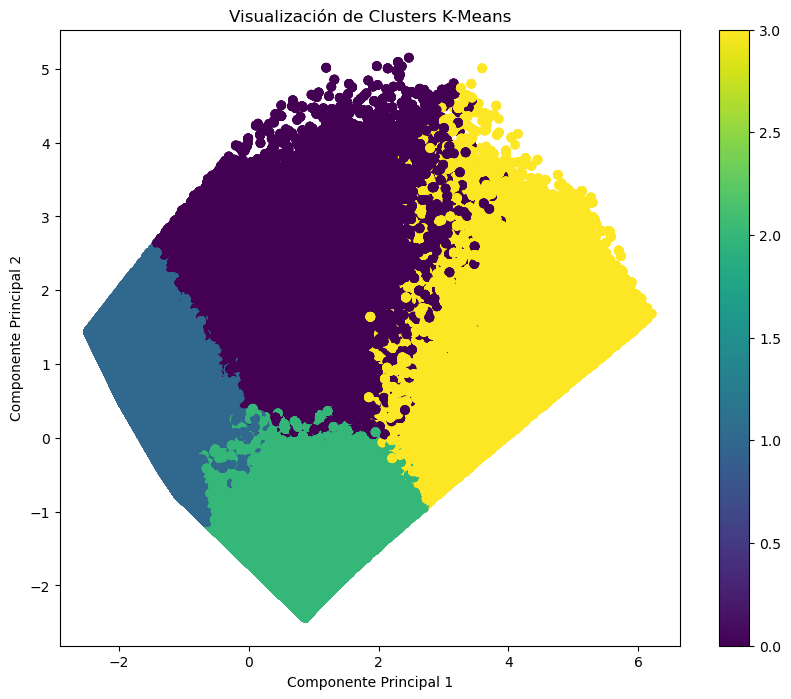

In [3]:
#Aquí se calculan los clusters climáticos para la producción y se asigan al dataframe df_merged.
df_merged=VN.clusterizar_produccion(df_merged, 4)

In [4]:
#Aquí se aplican la función para calcular los shifts de eficiencia en función de los días y el clima
df_1=VN.hacer_shifts_produccion(df_merged, 'eficiencia_real')

In [5]:
#Se aplica el modelo para el cálculo de la producción.
#Esta función devuelve el valor del medium squared error, los índices del train y del test 
#y los valores predichos. 

#Los valores numéricos pertenecen a n_estimators, max_depth y min_samples_split por este orden, se pueden 
#modificar si así se desea.

mse, mae, idx_train, idx_test, y_pred=VN.modelo_produccion(df_1, 100, 30, 5)

In [6]:
#Estos valores están calculados en función del work rate de las instalaciones, por lo que
#NO ESTÁN EN kWh
print('El MSE es de:', mse)
print('El RMSE es de: ', round((mse**0.5), 5))
print('El MAE es de:', mae)

El MSE es de: 0.0011887897402164
El RMSE es de:  0.03448
El MAE es de: 0.012519741707707567
